In [86]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler

In [87]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [88]:
dataset_df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [89]:
dataset_df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


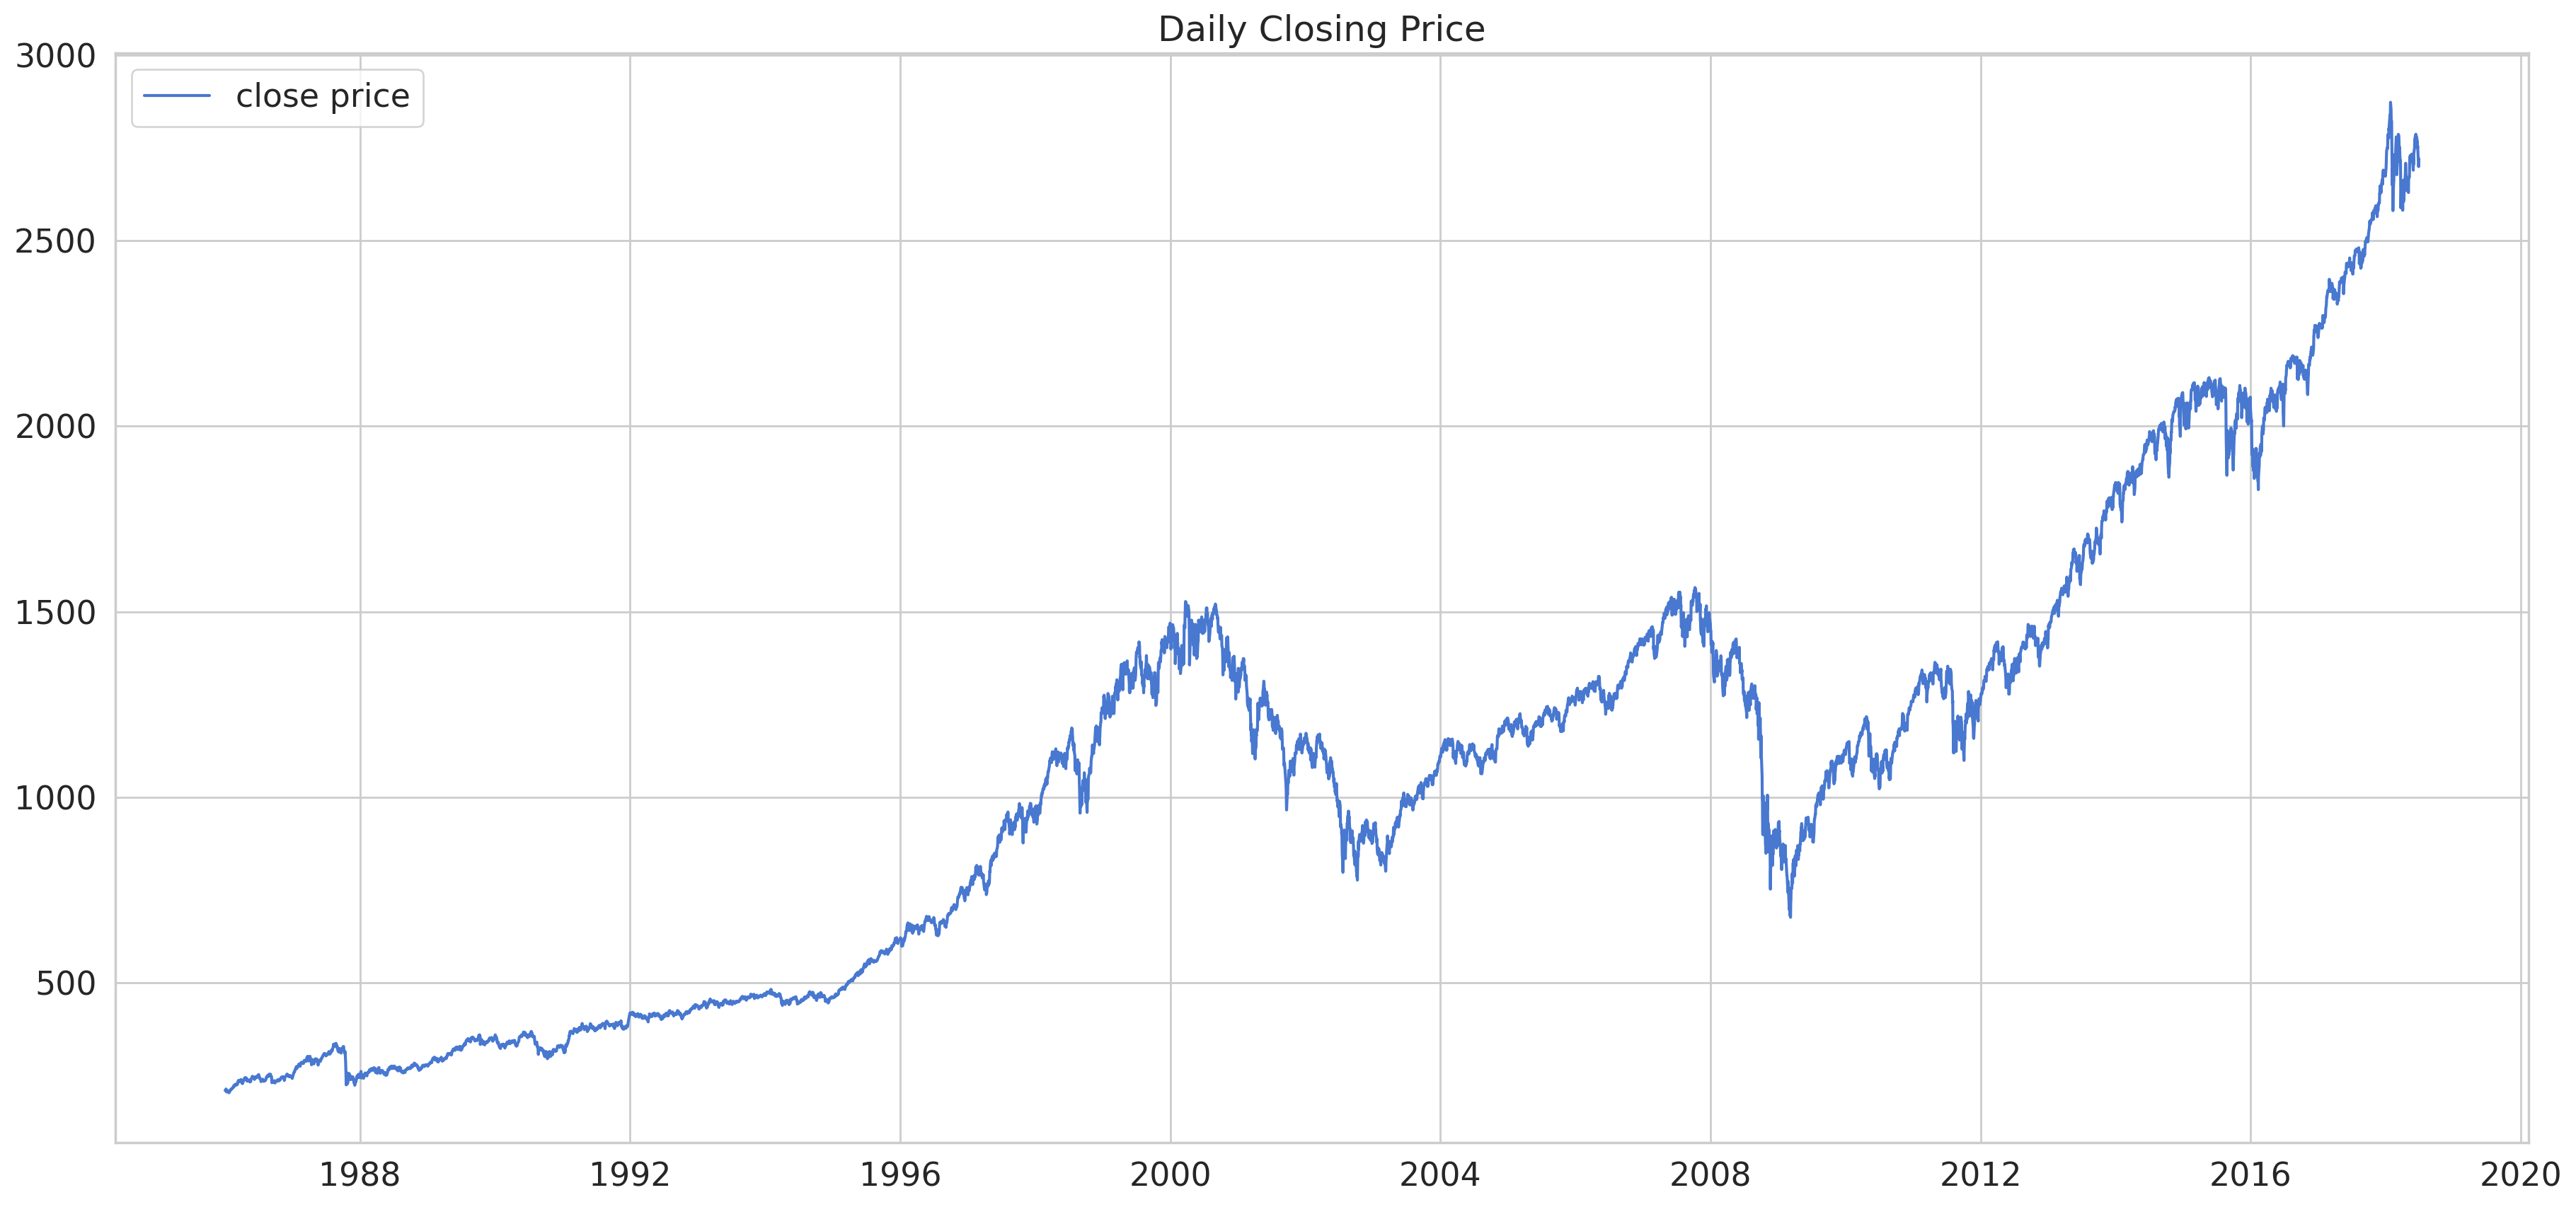

In [90]:
plt.plot(dataset_df, label='close price')
plt.title('Daily Closing Price')
plt.legend();

In [91]:
train_size = int(len(dataset_df) * 0.95)
test_size = len(dataset_df) - train_size
train, test = dataset_df.iloc[0:train_size], dataset_df.iloc[train_size:len(dataset_df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

<ipython-input-92-419ee0323bae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-92-419ee0323bae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [93]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [94]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [95]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [96]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 24s 92ms/step - loss: 0.1747 - val_loss: 0.2678
Epoch 2/10
218/218 [==============================] - 13s 61ms/step - loss: 0.1024 - val_loss: 0.2309
Epoch 3/10
218/218 [==============================] - 8s 36ms/step - loss: 0.0961 - val_loss: 0.2457
Epoch 4/10
218/218 [==============================] - 9s 42ms/step - loss: 0.1213 - val_loss: 0.3206
Epoch 5/10
218/218 [==============================] - 8s 37ms/step - loss: 0.1317 - val_loss: 0.3249
Epoch 6/10
218/218 [==============================] - 9s 40ms/step - loss: 0.1274 - val_loss: 0.1958
Epoch 7/10
218/218 [==============================] - 12s 56ms/step - loss: 0.1269 - val_loss: 0.1343
Epoch 8/10
218/218 [==============================] - 8s 35ms/step - loss: 0.1219 - val_loss: 0.1332
Epoch 9/10
218/218 [==============================] - 8s 39ms/step - loss: 0.1290 - val_loss: 0.1081
Epoch 10/10
218/218 [==============================] - 9s 40ms/step - loss: 0.1351 - val

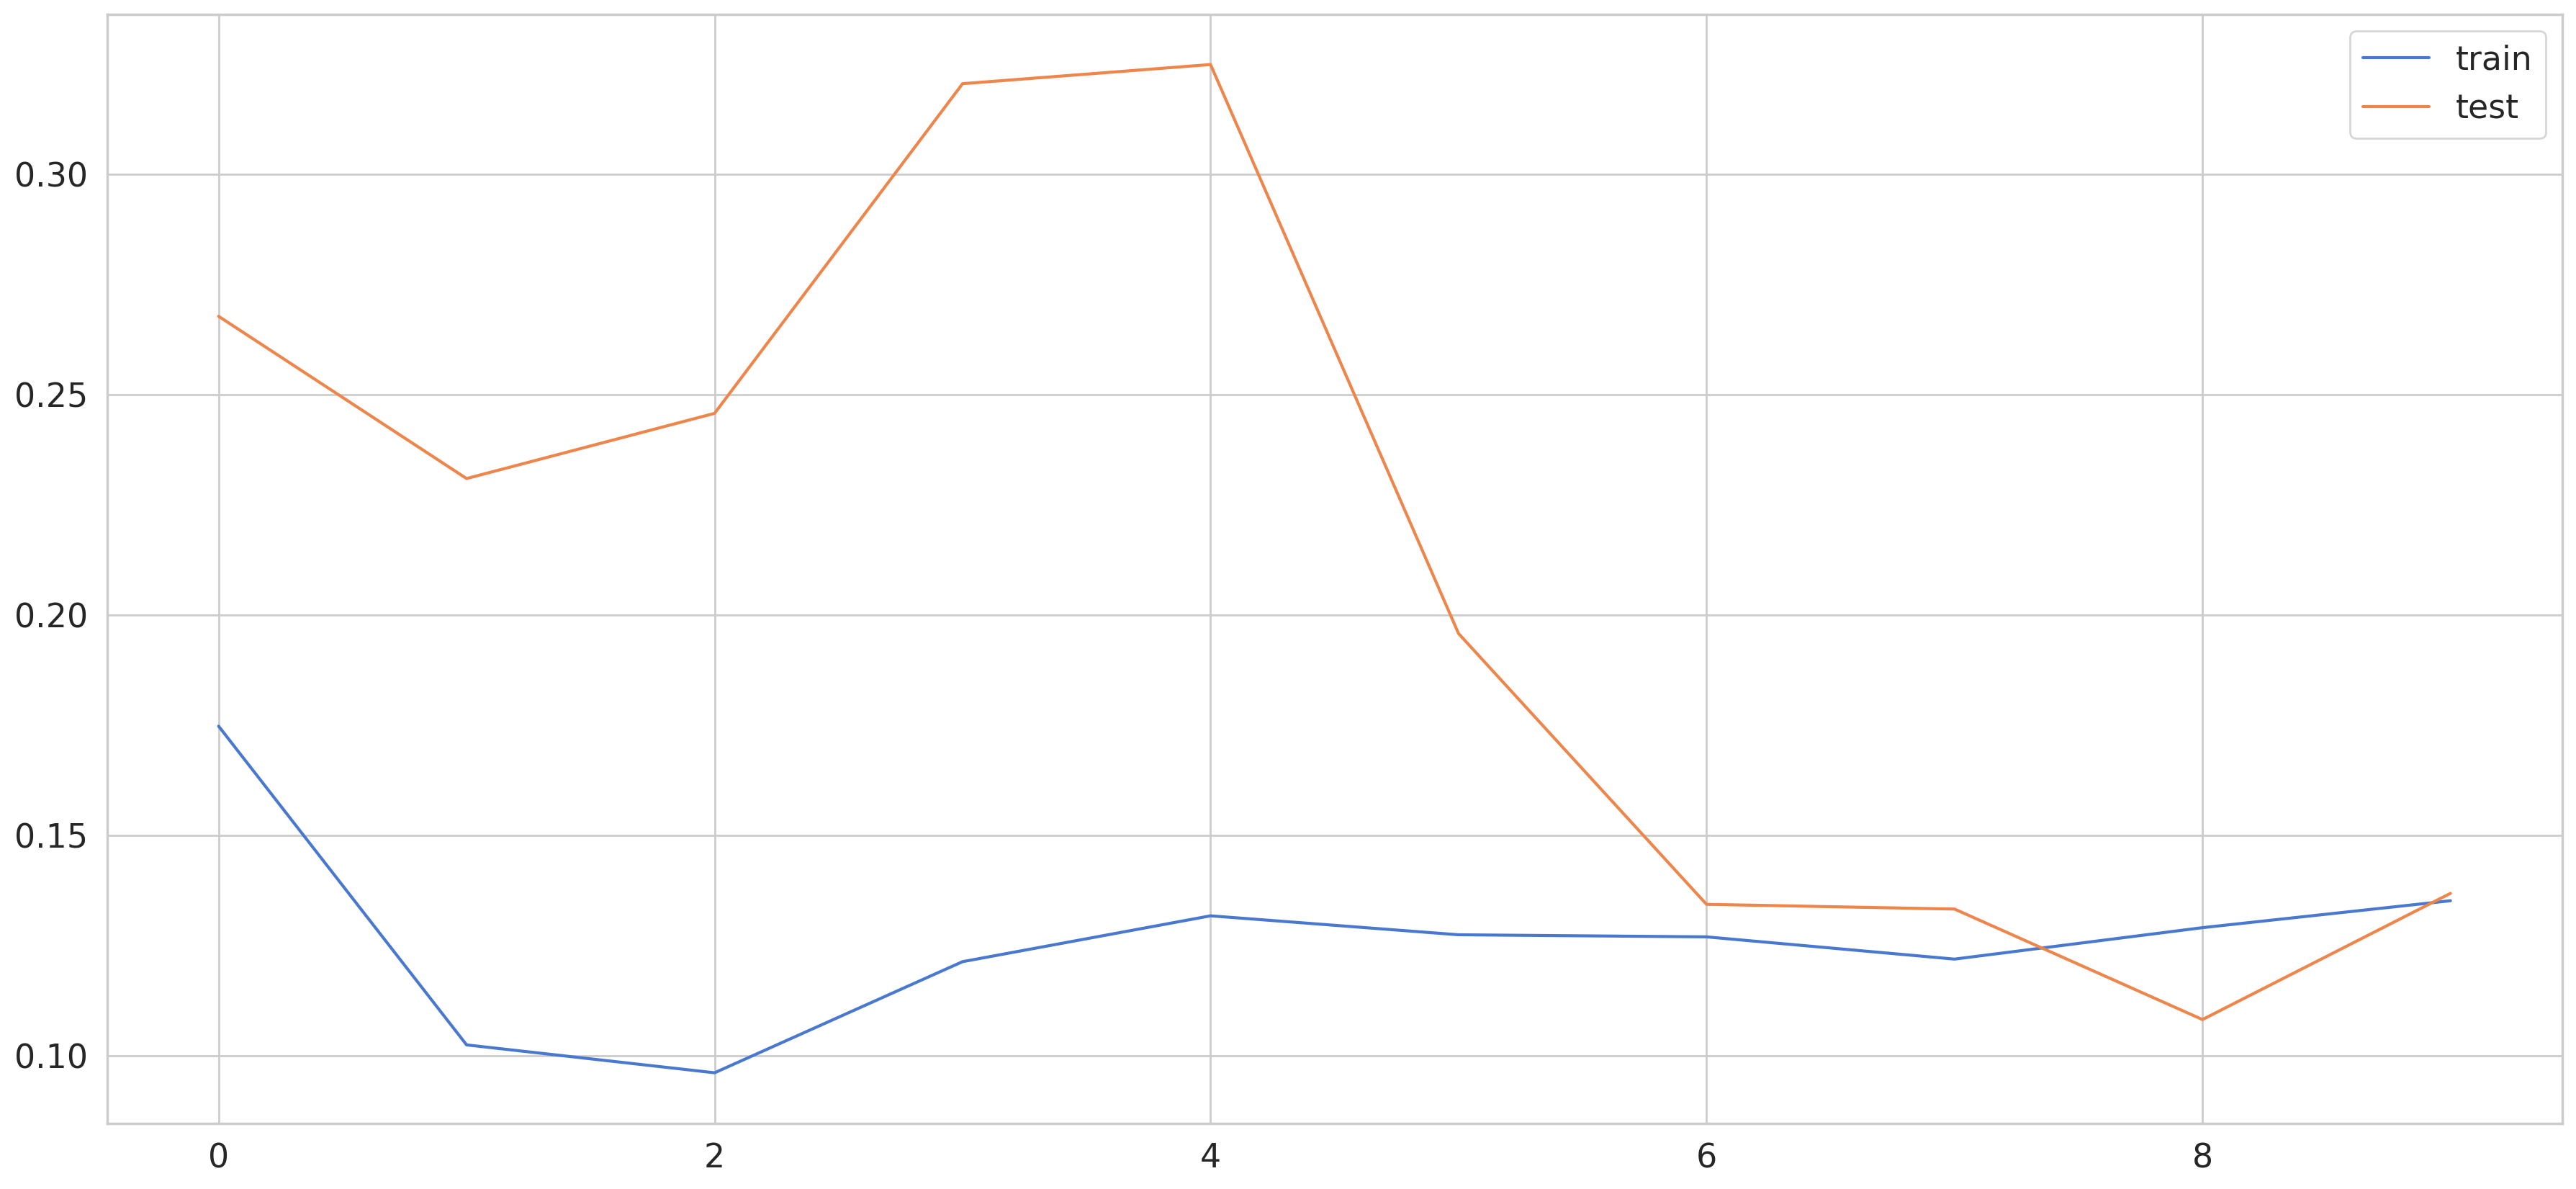

In [97]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [98]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 4s 13ms/step


<ipython-input-99-799f7bf2afcd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


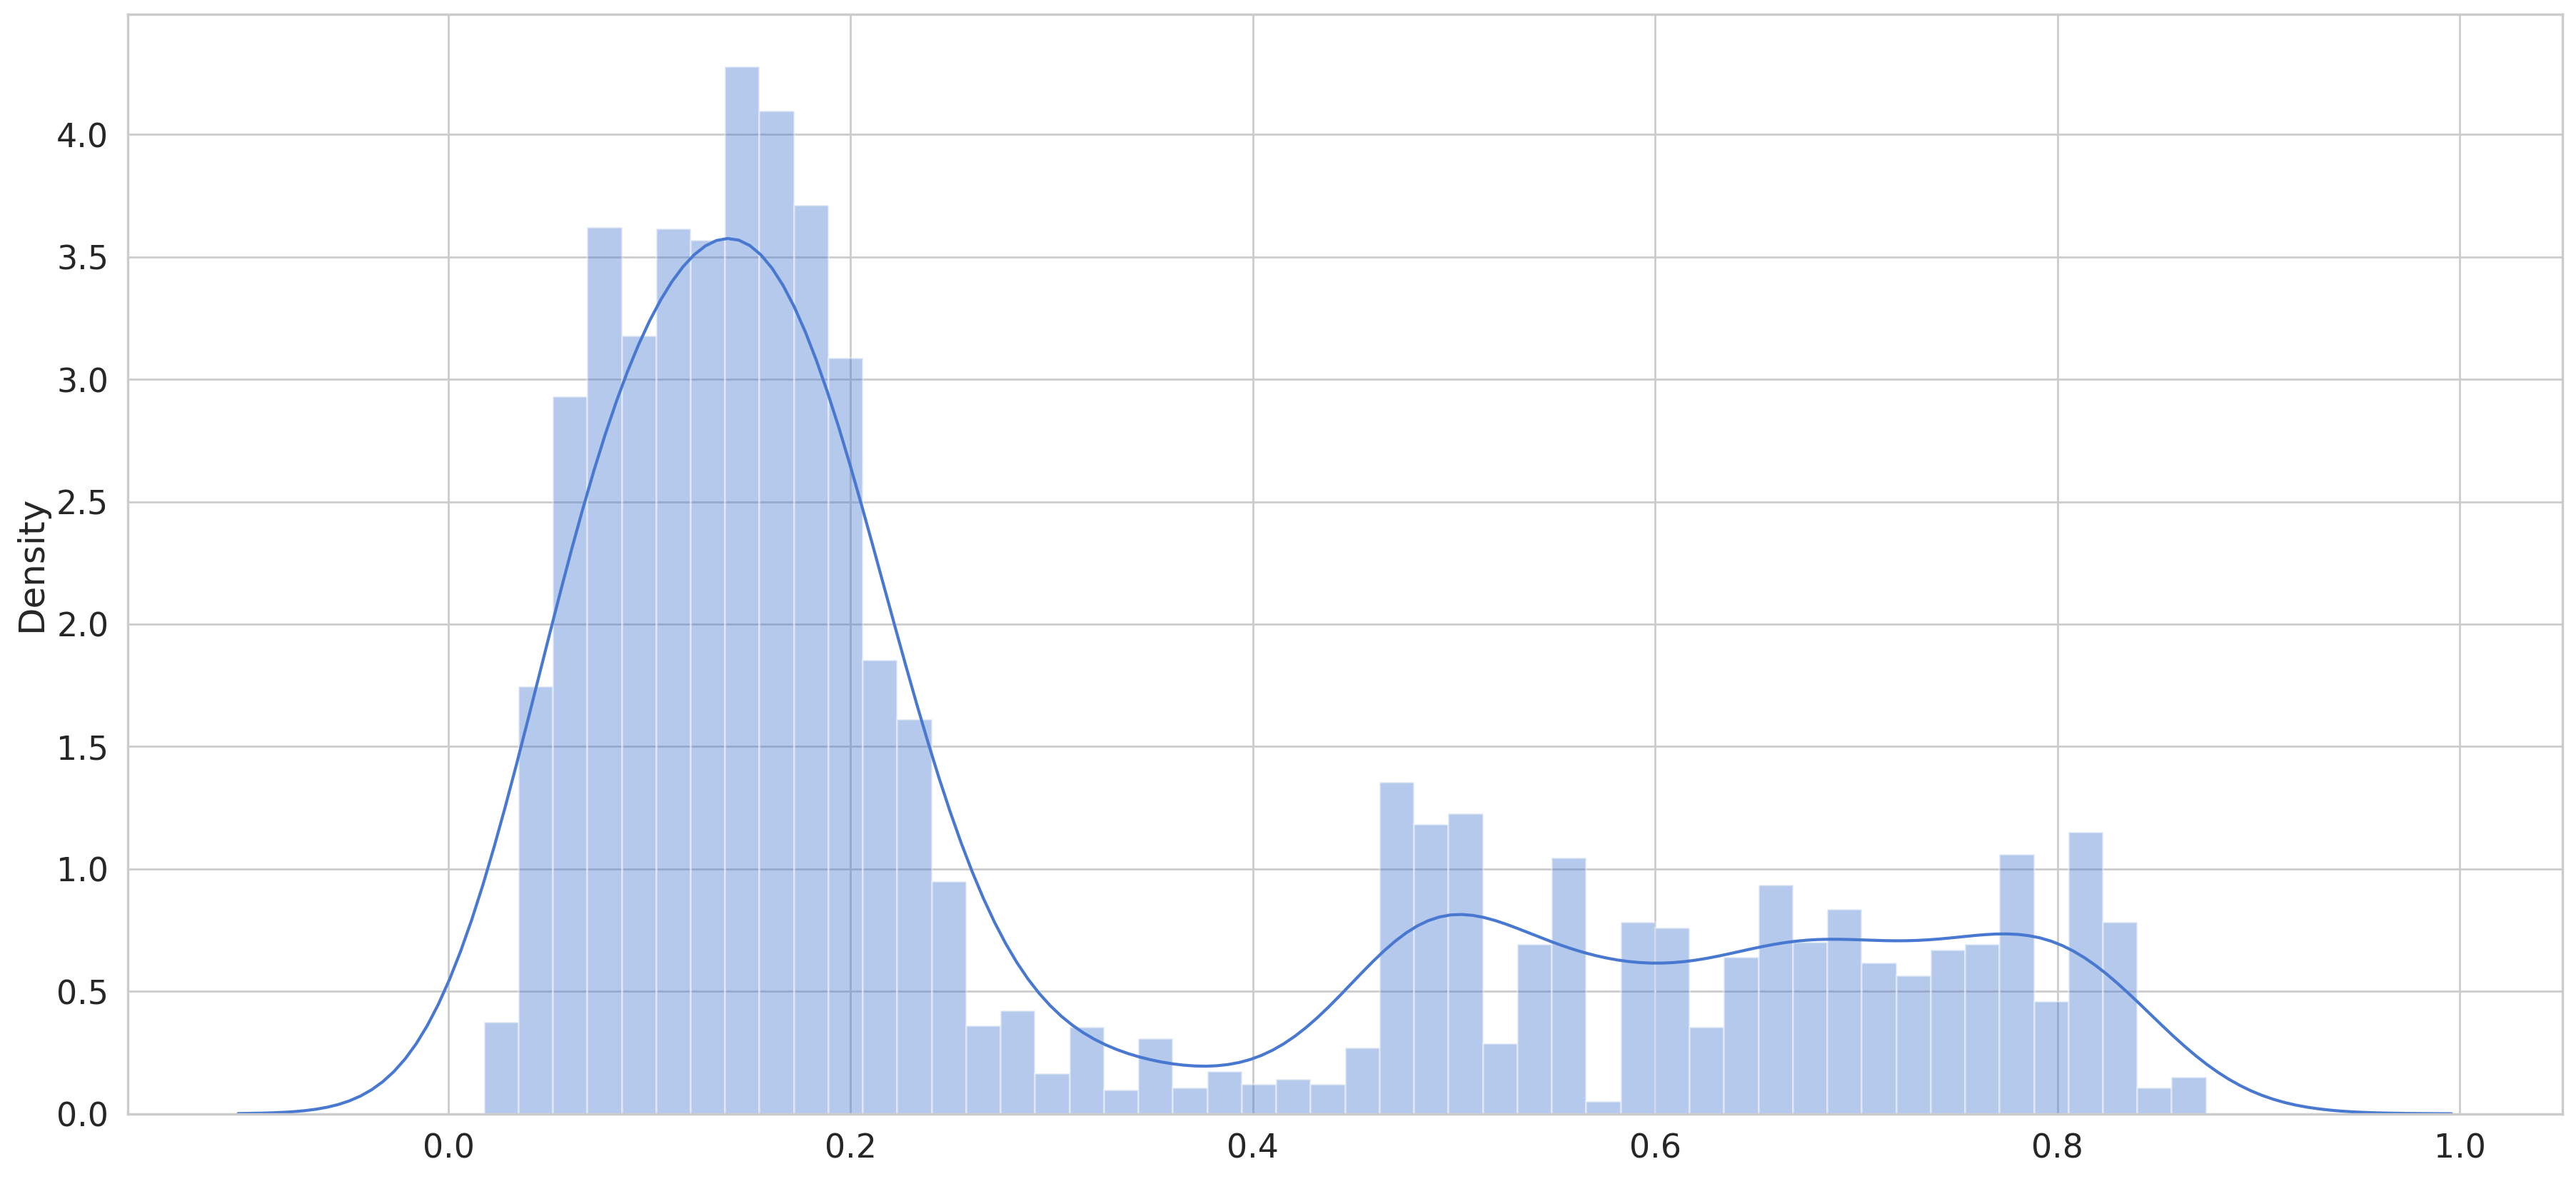

In [99]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [100]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 13ms/step


In [101]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

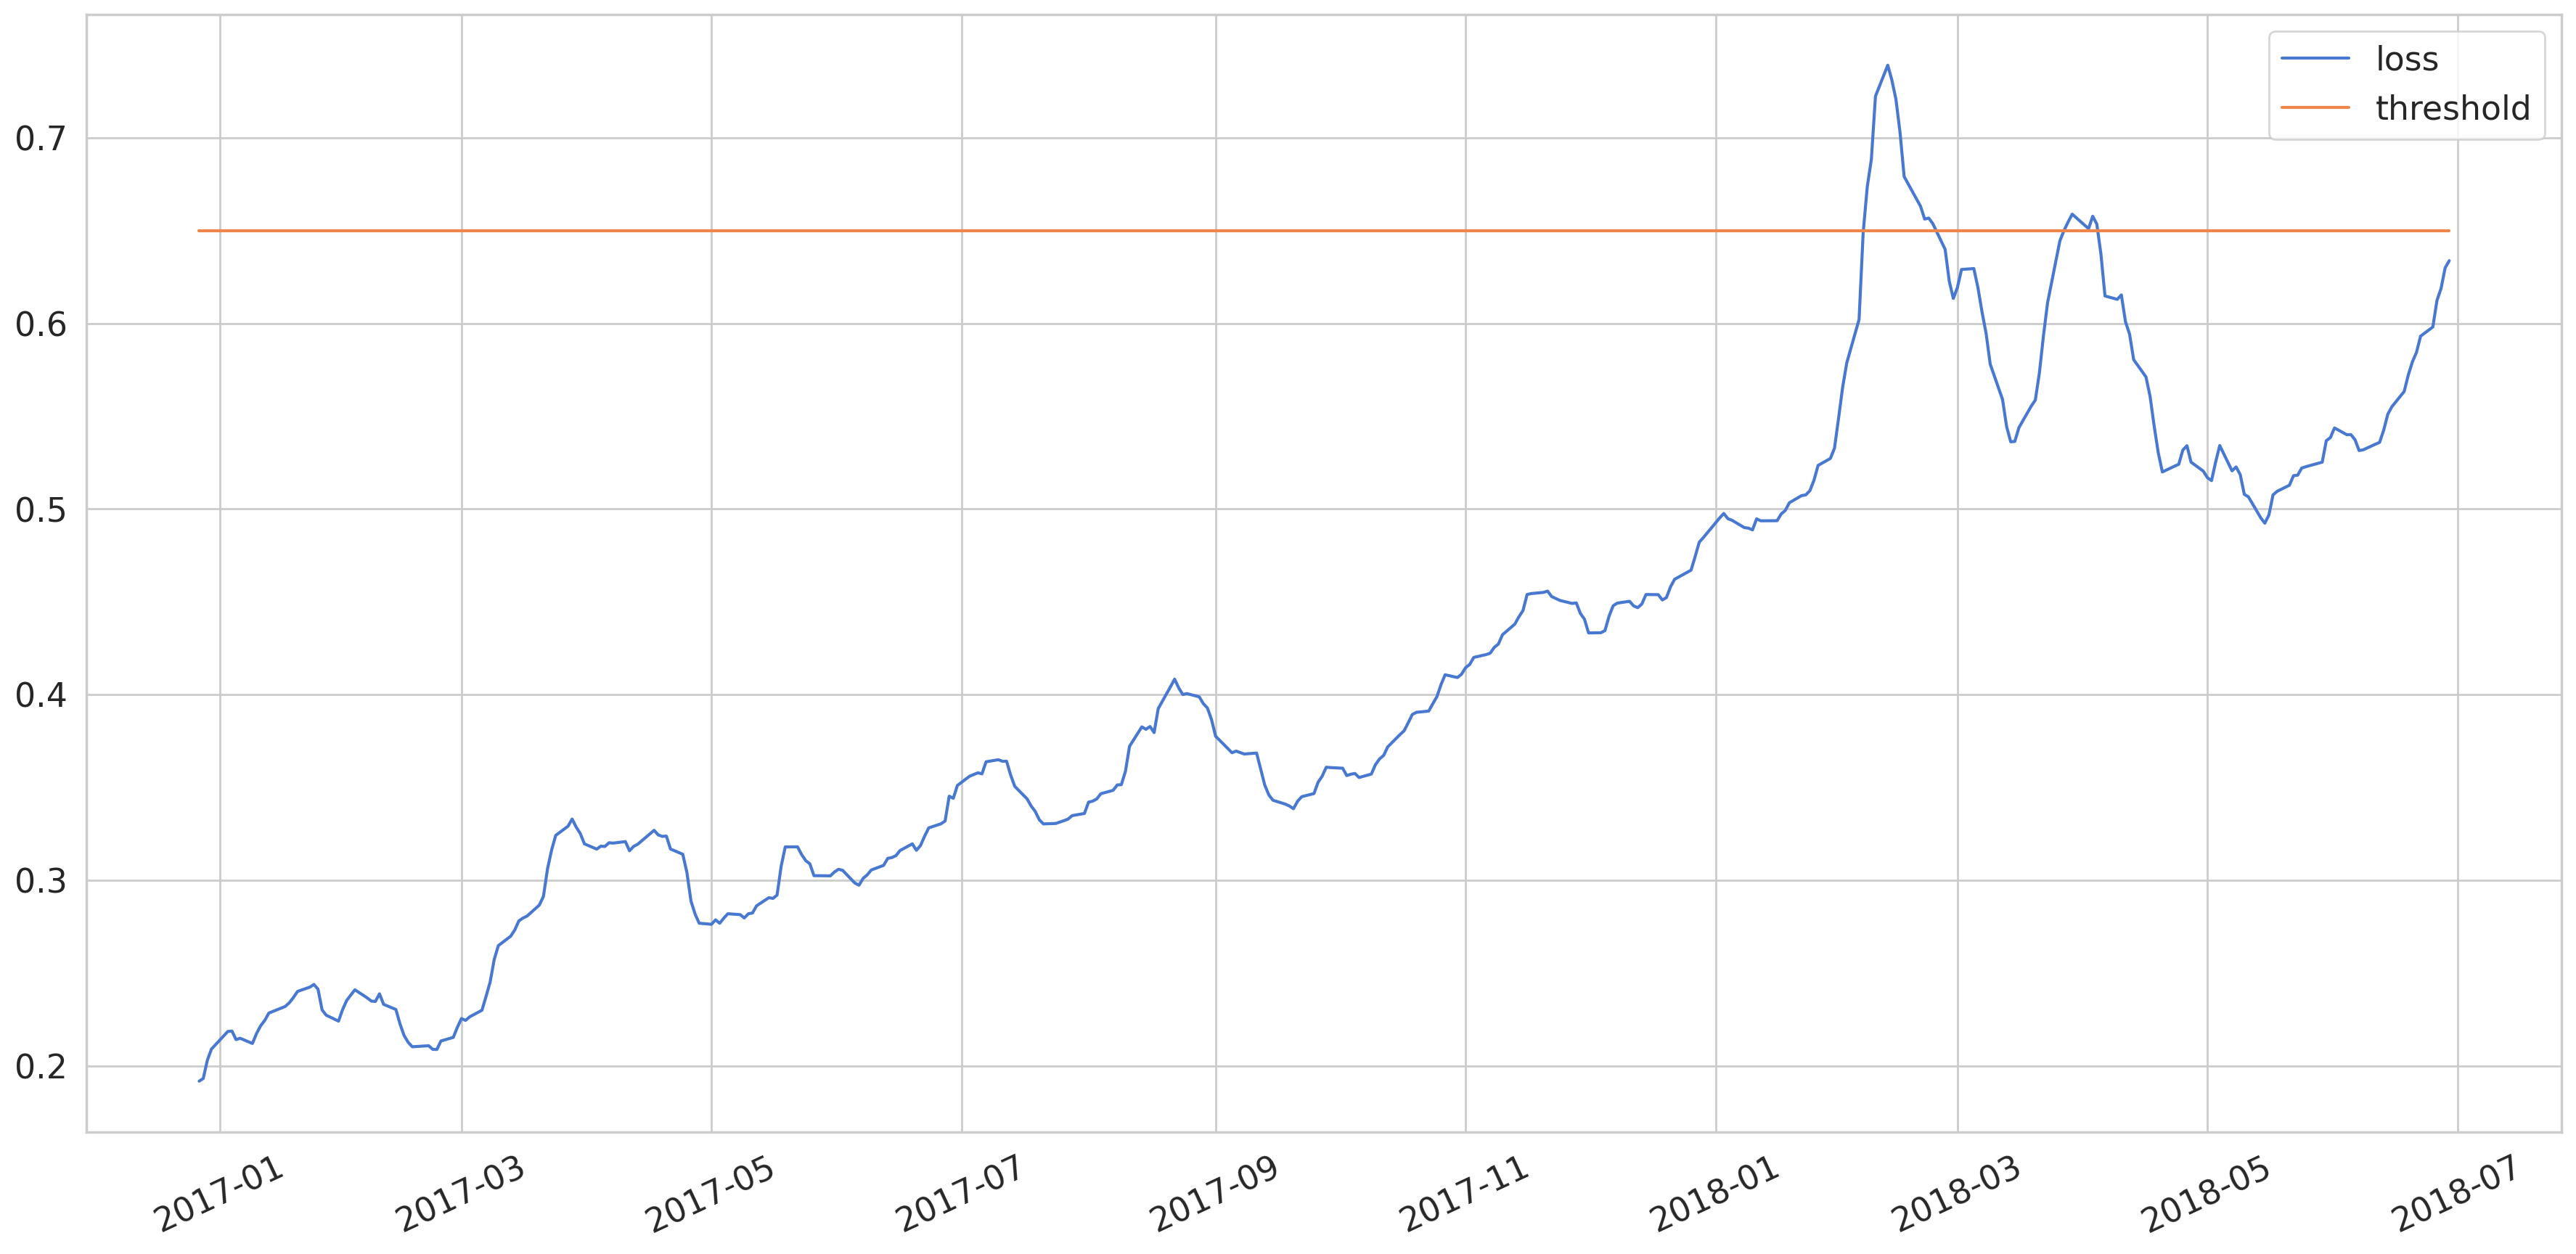

In [102]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [103]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-07,0.673553,0.65,True,3.168136
2018-02-08,0.688321,0.65,True,2.979068
2018-02-09,0.722275,0.65,True,3.051476
2018-02-12,0.738997,0.65,True,3.119939
2018-02-13,0.730988,0.65,True,3.132975


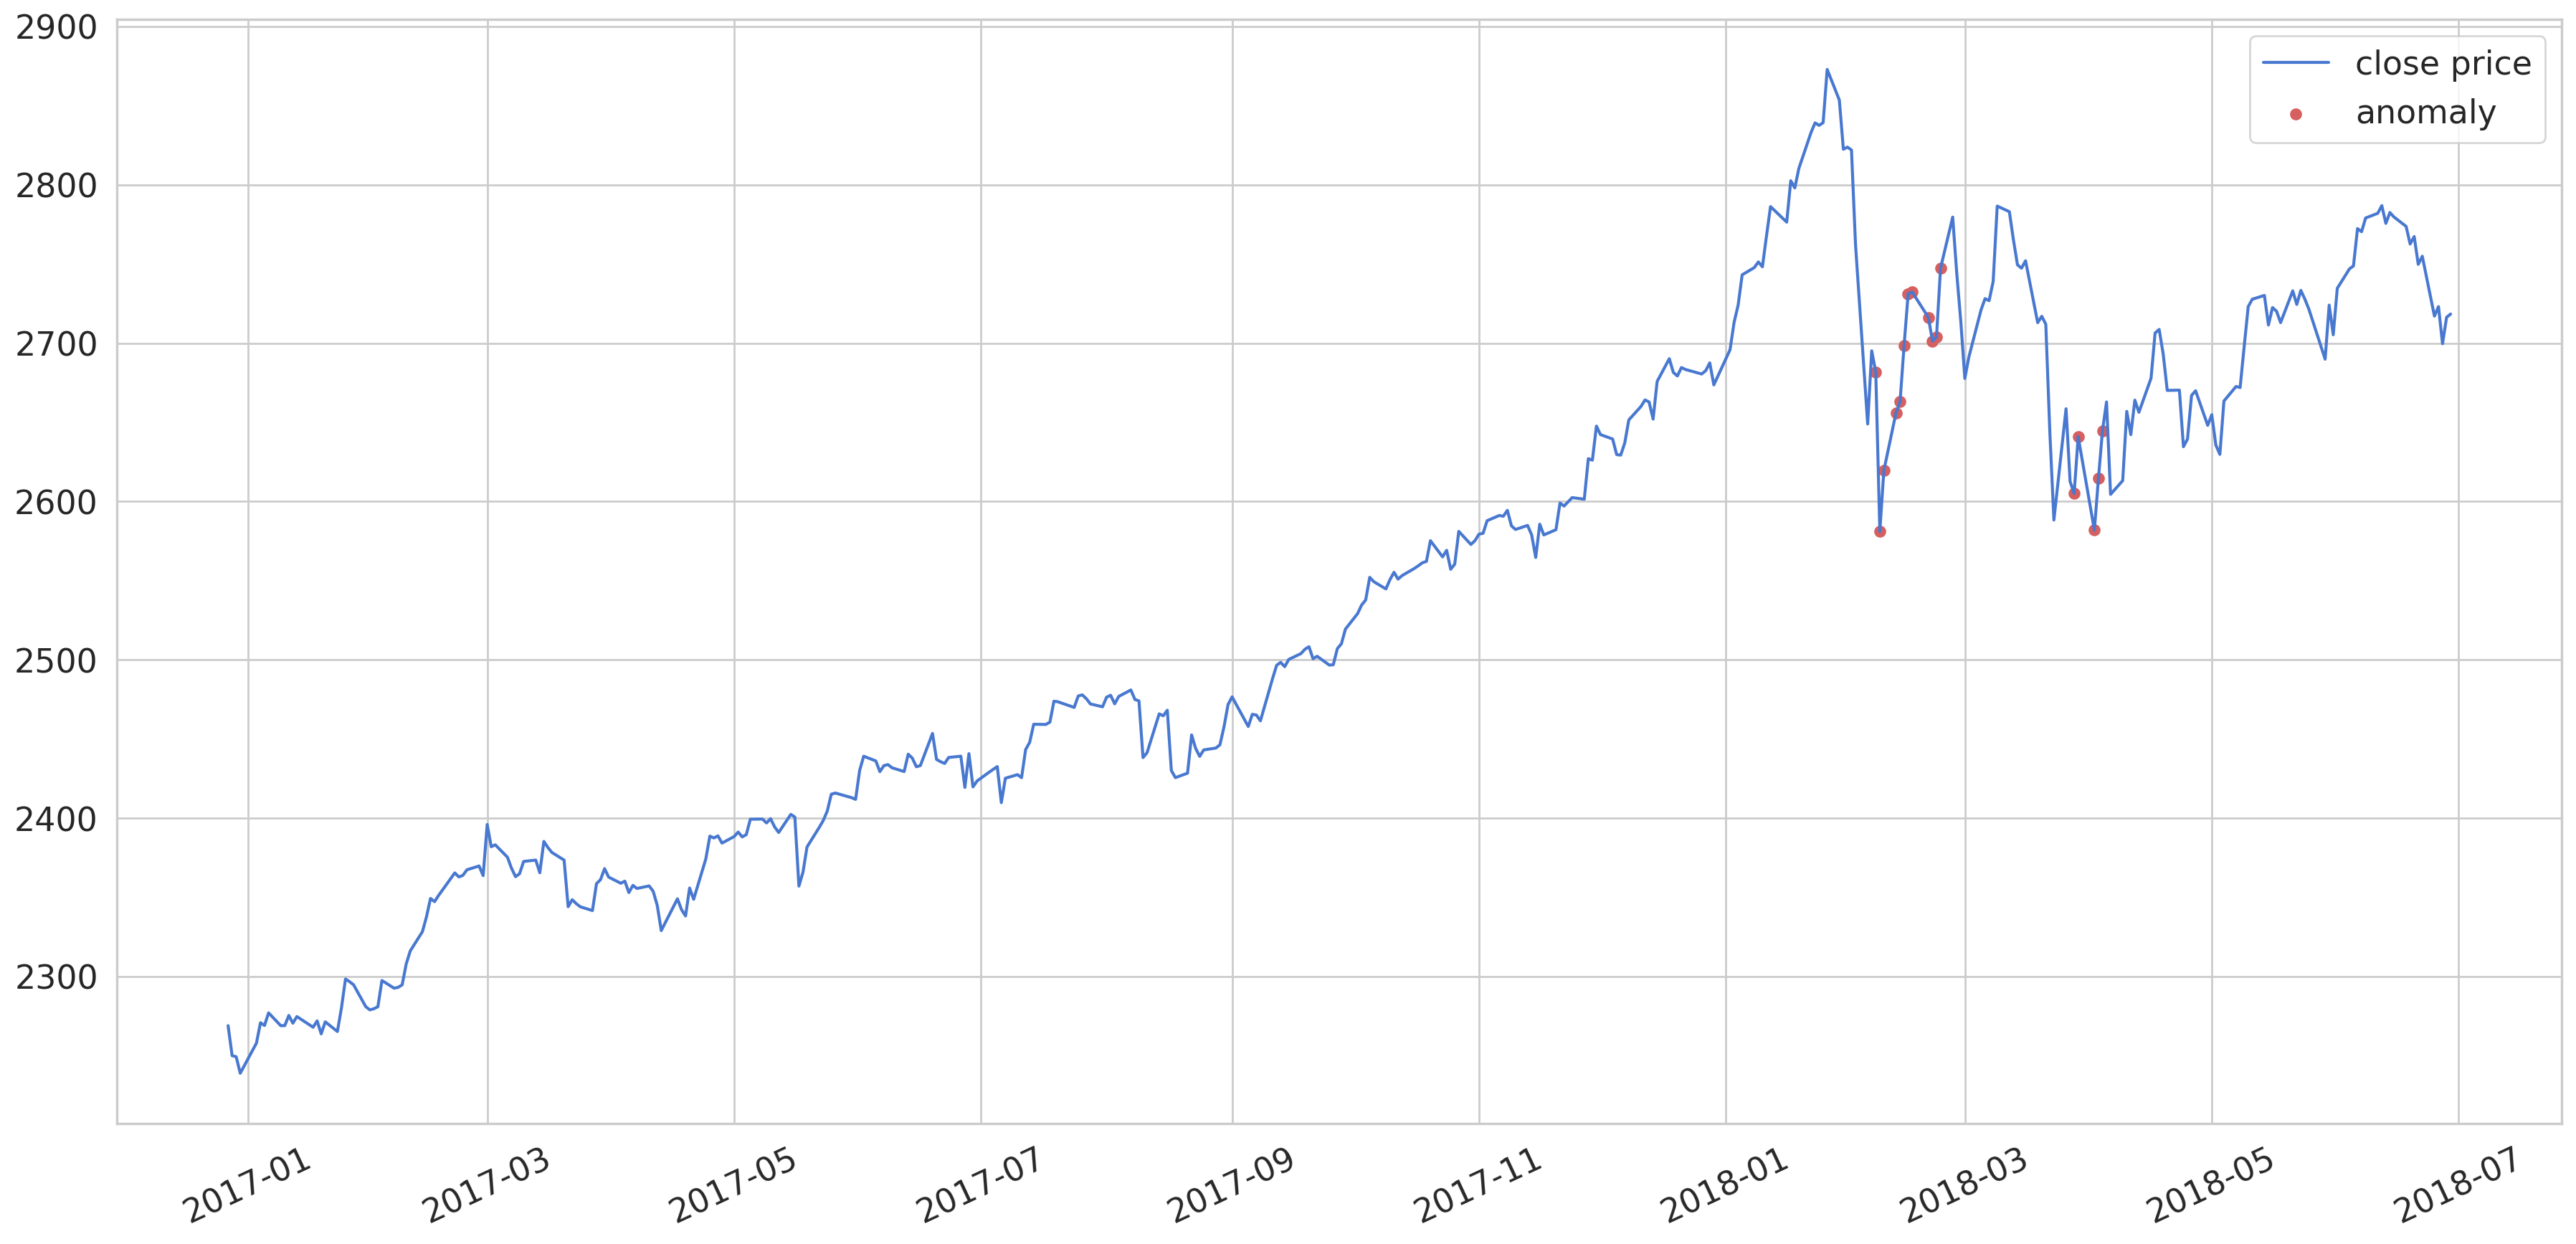

In [104]:
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(-1, 1)),
    label='close price'
)
plt.scatter(
    anomalies.index,
    scaler.inverse_transform(anomalies.close.values.reshape(-1, 1)),
    color=sns.color_palette()[3],
    s=25,
    label='anomaly'
)

plt.xticks(rotation=25)
plt.legend();